<a href="https://colab.research.google.com/github/rajatrh/MTA-Schedule-Delays/blob/master/User_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from dateutil import tz
import math

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
df_crowd_source = pd.read_csv('/content/drive/My Drive/523 524/CrowdsourcingLocationLog.csv')

In [0]:
df_stations = pd.read_csv('/content/drive/My Drive/523 524/meta_data/stops_lirr.csv')

In [0]:
def convertToDate(dateTime):
  cur = pd.to_datetime(dateTime, errors='coerce')
  cur.tz_localize(None)
  return cur.date()

In [0]:
df_crowd_source['_created_at'] = df_crowd_source.apply(lambda x: convertToDate(x['_created_at']),axis=1)

In [0]:
df_crowd_source.shape

(1486295, 6)

In [0]:
df_stations.head(1)

,Unnamed: 0,stop_id,stop_name,stop_desc,stop_lat,stop_lon,stop_url,wheelchair_boarding
0,0,237,Penn Station,34th Street between 7th & 8th Avenues.,40.750588,-73.993584,http://lirr42.mta.info/stationInfo.php?id=8,1


In [0]:
df_crowd_source.head(1)

,userId,_created_at,locationTime,latitude,longitude,horizontalAccuracy
0,d97ea50e-6dff-40e8-93db-19205a19b976,2019-07-01,8:00:01 PM,40.741217,-73.637016,10.0


In [0]:
df_userCount = df_crowd_source.groupby('userId')['userId'].count().to_frame('count')
df_userCount.sort_values(by="count", ascending=False).head(3)

,count
userId,
615d12dc-e77c-4aef-a953-007249f8492e,18963
a1bb8718-6999-4892-95fb-66c4601fc891,16155
7f72fd31-0cbc-46cd-8c59-63928eb56ed5,15435


In [0]:
df_crowd_source[df_crowd_source['userId'] == '615d12dc-e77c-4aef-a953-007249f8492e'].groupby('_created_at').count()

,userId,locationTime,latitude,longitude,horizontalAccuracy
_created_at,,,,,
2020-01-04,187,187,187,187,187
2020-01-05,2803,2803,2803,2803,2803
2020-01-06,2264,2264,2264,2264,2264
2020-01-07,2813,2813,2813,2813,2813
2020-01-08,2816,2816,2816,2816,2816
2020-01-09,2725,2725,2725,2725,2725
2020-01-10,2822,2822,2822,2822,2822
2020-01-11,2533,2533,2533,2533,2533


In [0]:
df_user_date_count = df_crowd_source.groupby([
    pd.Grouper('userId'),
    pd.Grouper('_created_at')]
)['userId'].count().to_frame('count')

In [0]:
df_user_date_count.head(3)

count
userId                               _created_at       
0003476a-5cd9-4e3f-b180-208bbaf03363 2019-07-17      95
                                     2019-07-18      14
                                     2019-07-19     129

In [0]:
df_crowd_source['_created_at'].describe()

count        1486295
unique           214
top       2019-07-03
freq           47661
Name: _created_at, dtype: object

In [0]:
q2b = df_crowd_source.groupby('_created_at')['_created_at'].count().to_frame('count')
q2b = q2b.add_suffix('_').reset_index()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


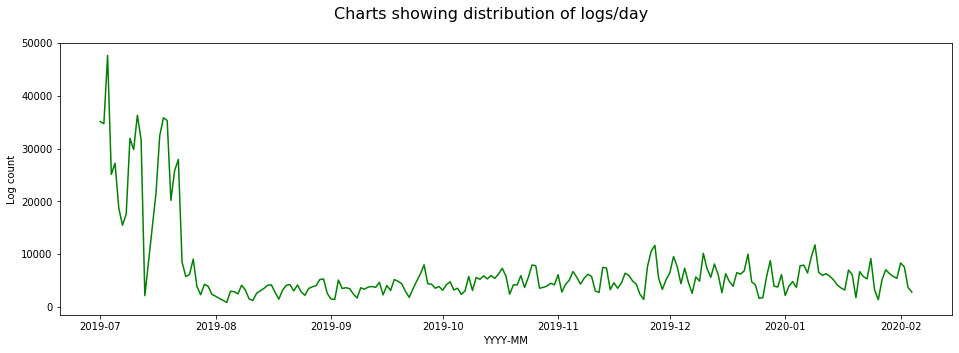

In [0]:
plt.figure(figsize=(16,5))
plt.suptitle('Charts showing distribution of logs/day'
, fontsize=16)
sb.lineplot(y='count_', x='_created_at', data=q2b, color='green')
plt.xlabel("YYYY-MM")
plt.ylabel("Log count")
plt.show()

In [0]:
# Haversine Formula
def distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [0]:
i=0
for cs_index, cs_row in df_crowd_source.iterrows():
  if i%1000 == 0:
    print(i)
  i=i+1
  if cs_row['stop_id'] != 90:
    continue
  df_crowd_source.loc[cs_index, 'stop_id'] = -1
  for s_index, s_row in df_stations.iterrows():
    dist = distance(cs_row.latitude, cs_row.longitude, s_row.stop_lat, s_row.stop_lon)
    if dist < 0.6:
      df_crowd_source.loc[cs_index, 'stop_id'] =s_row.stop_id
      break
  

In [0]:
df_crowd_source['stop_id'].value_counts()

 90     1214172
-1       116123
 102      32013
 237      10118
 214       6214
         ...   
 73          11
 85          10
 216          8
 154          5
 101          4
Name: stop_id, Length: 124, dtype: int64

In [0]:
df_crowd_source.to_csv('cleaned_df_crowd_source')

In [0]:
df_fin_crowd_source = pd.read_csv('/content/drive/My Drive/523 524/meta_data/fin.csv')

In [0]:
df_fin_crowd_source.head(10)

In [0]:
df_fin_crowd_source['stop_id'].value_counts()

-1      491136
 102    109216
 237     40335
 214     22411
 92      17979
         ...  
 123        76
 65         53
 216        42
 101        40
 73         16
Name: stop_id, Length: 125, dtype: int64

In [0]:
df_st = df_fin_crowd_source.groupby('stop_id')['stop_id'].count().to_frame('count')
df_st = df_st.add_suffix('_').reset_index()

In [0]:
df_st = df_st.iloc[1:]

In [0]:
for index1, row1 in df_st.iterrows():
  for index2, row2 in df_stations.iterrows():
    if row2['stop_id'] == row1['stop_id']:
      df_st.loc[index1, 'stop_name'] = row2['stop_name']
      df_st.loc[index1, 'stop_lat'] = row2['stop_lat']
      df_st.loc[index1, 'stop_lon'] = row2['stop_lon']

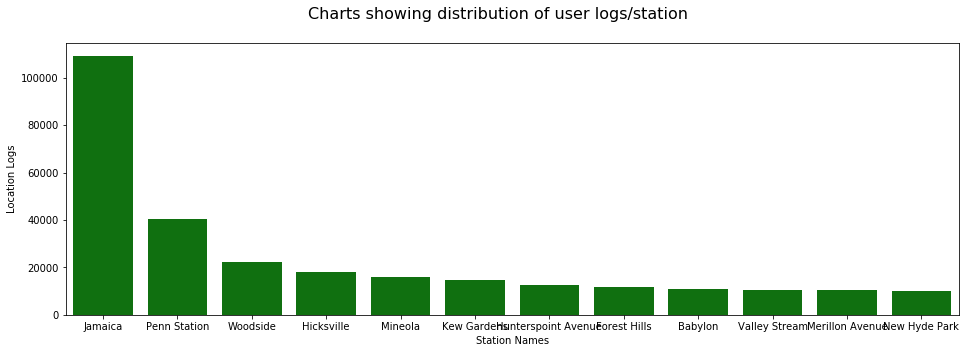

In [0]:
plt.figure(figsize=(16,5))
plt.suptitle('Charts showing distribution of user logs/station'
, fontsize=16)
sb.barplot(y='count_', x='stop_name', data=df_st.sort_values(by="count_", ascending=False).head(12), color='green')
plt.xlabel("Station Names")
plt.ylabel("Location Logs")
plt.show()

In [0]:
df_st.sort_values(by="count_", ascending=False).head(12)

,stop_id,count_,stop_name,stop_lat,stop_lon
57,102,109216,Jamaica,40.699608,-73.808530
123,237,40335,Penn Station,40.750588,-73.993584
113,214,22411,Woodside,40.745851,-73.902975
52,92,17979,Hicksville,40.767175,-73.528533
75,132,15775,Mineola,40.740347,-73.640863
58,107,14743,Kew Gardens,40.709649,-73.830888
50,90,12576,Hunterspoint Avenue,40.742390,-73.946790
30,55,11571,Forest Hills,40.719576,-73.844814
15,27,10792,Babylon,40.700689,-73.324056
111,211,10505,Valley Stream,40.661518,-73.704759


## Plot the stationwise -> hourly, weekly breakdowns

In [0]:
plt.figure(figsize=(5,4))
stationNumber = 14
df_102 = df_fin_crowd_source[df_fin_crowd_source['stop_id'] == stationNumber]
df_102['parsed_time_hour'] = pd.to_datetime(df_102['locationTime'], errors='coerce').dt.hour
df_102['parsed_day_of_week'] = pd.to_datetime(df_102['_created_at'], errors='coerce').dt.dayofweek

df_102.groupby('parsed_time_hour')['stop_id'].count().plot.bar()

In [0]:
df_102.groupby('parsed_day_of_week')['stop_id'].count().plot.bar()

## Loop through to find each stations busiest hour/day of the week

In [0]:
for s_index, s_row in df_st.iterrows():
  stationNumber = s_row['stop_id']
  df_stt = df_fin_crowd_source[df_fin_crowd_source['stop_id'] == stationNumber]
  df_stt['parsed_time_hour'] = pd.to_datetime(df_stt['locationTime'], errors='coerce').dt.hour
  df_stt['parsed_day_of_week'] = pd.to_datetime(df_stt['_created_at'], errors='coerce').dt.dayofweek
  df_st.loc[s_index, 'busiest_hour'] = df_stt.groupby('parsed_time_hour')['userId'].count().sort_values(ascending=False).keys()[0]
  df_st.loc[s_index, 'busiest_day_of_week'] = df_stt.groupby('parsed_day_of_week')['userId'].count().sort_values(ascending=False).keys()[0]

In [0]:
df_st

,stop_id,count_,stop_name,stop_lat,stop_lon,busiest_hour,busiest_day_of_week
1,1,680,Albertson,40.772063,-73.641691,19.0,3.0
2,2,2608,Auburndale,40.761443,-73.789959,18.0,3.0
3,4,374,Amagansett,40.980040,-72.132334,14.0,6.0
4,8,4492,Amityville,40.680249,-73.420312,16.0,3.0
5,11,2803,Broadway,40.761653,-73.801766,19.0,3.0
...,...,...,...,...,...,...,...
120,225,7675,Baldwin,40.656732,-73.607162,18.0,3.0
121,226,6497,Merrick,40.663800,-73.550621,18.0,3.0
122,233,1605,Westhampton,40.830305,-72.650325,17.0,6.0
123,237,40335,Penn Station,40.750588,-73.993584,9.0,3.0


In [0]:
!pip install gmaps

In [0]:
import gmaps
import gmaps.datasets
from ipywidgets.embed import embed_minimal_html

In [0]:
gmaps.configure(api_key='gmaps_api_key') 

In [0]:
locations = df_st[['stop_lat', 'stop_lon']]

weights = df_st['count_']

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights, point_radius=11.0))
fig

Figure(layout=FigureLayout(height='420px'))

In [0]:
embed_minimal_html('export.html', views=[fig])